In [61]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import random
from sympy import symbols, diff, lambdify, parse_expr
import sympy as sp

#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

def relu(z):
    """The ReLU function."""
    return np.maximum(0, z)

def relu_prime(z):
    """Derivative of the ReLU function."""
    return (z > 0).astype(float)

def tanh(z):
    """The tanh function."""
    return np.tanh(z)

def tanh_prime(z):
    """Derivative of the tanh function."""
    return 1.0 - tanh(z)**2

def leaky_relu(z, alpha=0.01):
    """The Leaky ReLU function."""
    return np.where(z > 0, z, z * alpha)

def leaky_relu_prime(z, alpha=0.01):
    """Derivative of the Leaky ReLU function."""
    return np.where(z > 0, 1, alpha)

# Function mapping
activations = {'sigmoid': sigmoid, 'relu': relu, 'tanh': tanh, 'leaky_relu': leaky_relu}
derivatives = {'sigmoid': sigmoid_prime, 'relu': relu_prime, 'tanh': tanh_prime, 'leaky_relu': leaky_relu_prime}

def add_custom_activation_function(name, function, variable):
    """Add a custom activation function and its derivative to the function mappings."""
    global activations, derivatives
    parsed_function = parse_expr(function)
    parsed_derivative = diff(parsed_function, variable)
    
    # Convert the sympy expressions to lambda functions
    activations[name] = lambdify(variable, parsed_function, "numpy")
    derivatives[name] = lambdify(variable, parsed_derivative, "numpy")

# Function mapping
activations = {'sigmoid': sigmoid, 'relu': relu, 'tanh': tanh, 'leaky_relu': leaky_relu}
derivatives = {'sigmoid': sigmoid_prime, 'relu': relu_prime, 'tanh': tanh_prime, 'leaky_relu': leaky_relu_prime}


class Network(object):

    def __init__(self, sizes, activation_functions):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network. The activation functions are 
        defined for each layer."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.activation_functions = [activations[func] for func in activation_functions]
        self.activation_derivatives = [derivatives[func] for func in activation_functions]
        self.biases = [np.random.normal(0,0.1,(y, 1)) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) * np.sqrt(2 / (x + y)) for x, y in zip(sizes[:-1], sizes[1:])]
            
    def check_weights_biases(self):
        for i in range(self.num_layers - 1):
            if not(np.all(np.isfinite(self.weights[i])) and np.all(np.isfinite(self.biases[i]))):
                print(f"Layer {i + 1}: Non-number weights or biases detected.")
                return False
        print("All weights and biases are valid numbers.")
        return True
        
    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w, f in zip(self.biases, self.weights, self.activation_functions):
            a = f(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None, display=1):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if j%display==0:
                if test_data:
                    print( "Epoch {0}: {1} / {2}".format(
                        j, self.evaluate(test_data), n_test))
                else:
                    print( "Epoch {0}: Loss {1}".format(j, self.loss(training_data)))
        return

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and ``nabla_w`` 
        are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w, f in zip(self.biases, self.weights, self.activation_functions):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = f(z)
            activations.append(activation)

        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            self.activation_derivatives[-1](zs[-1])
            
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = self.activation_derivatives[-l](z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def loss(self, data):
        result = 0
        n = len(data)
        for x, y in data:
            yy = self.feedforward(x)
            result += (yy[0][0] - y)**2
        result /= 2*n
        return result
        

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def evaluate_data(self, data):
        result = np.array([])
        for x in data:
            y = self.feedforward(x)
            result = np.append(result, y[0][0])
        return result

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        result = output_activations-y
        return result
        



In [62]:
# Add a custom activation function
add_custom_activation_function('linear', 'x', 'x')

In [63]:
x = np.linspace(0, 1, 100)
y =  np.sin(5*x)+2*np.cos(10*x**2)
training_data = [[xx, yy] for xx, yy in zip(x, y)]
net = Network([1, 32, 32, 1], ['relu', 'relu', 'linear'])
net.SGD(training_data, 10000, 1, eta = 0.01, display=500)

Epoch 0: Loss 1.3546390330401423
Epoch 500: Loss 0.007736219995165498
Epoch 1000: Loss 0.004885564116493939
Epoch 1500: Loss 0.002114193421593869
Epoch 2000: Loss 0.002100097912756047
Epoch 2500: Loss 0.001542976675187728
Epoch 3000: Loss 0.0016328728158861233
Epoch 3500: Loss 0.0017405234539623585
Epoch 4000: Loss 0.0026281732400744305
Epoch 4500: Loss 0.0022772668464999717
Epoch 5000: Loss 0.005299321235815681
Epoch 5500: Loss 0.001443414466297266
Epoch 6000: Loss 0.0009669172043718525
Epoch 6500: Loss 0.0022271540334276247
Epoch 7000: Loss 0.0012853079981431119
Epoch 7500: Loss 0.002106875645823691
Epoch 8000: Loss 0.0006663900354901528
Epoch 8500: Loss 0.0007577006453114337
Epoch 9000: Loss 0.0006453007290823496
Epoch 9500: Loss 0.0009639797121164003


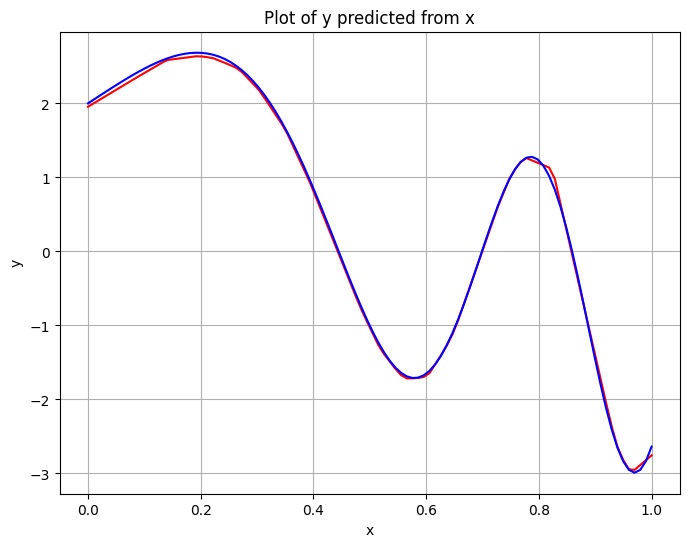

In [64]:
x = np.linspace(0, 1, 100)
y = net.evaluate_data(x)


# Create the plot
plt.figure(figsize=(8, 6))  # Optional: Specifies the size of the figure
plt.plot(x, y, color='red')

x = np.linspace(0, 1, 100)
y = np.sin(5*x)+2*np.cos(10*x**2)
training_data = [[xx, yy] for xx, yy in zip(x, y)]
XX = [xx for xx, yy in training_data]
YY = [yy for xx, yy in training_data]
plt.plot(XX, YY, color='blue')


plt.title('Plot of y predicted from x')  # Optional: Gives a title to your plot
plt.xlabel('x')  # Optional: Labels the x-axis
plt.ylabel('y')  # Optional: Labels the y-axis
plt.grid(True)  # Optional: Adds a grid to your plot
plt.show()

In [65]:
net.weights


[array([[-1.83178403],
        [-0.02626272],
        [ 0.10241072],
        [ 0.34979117],
        [-1.15820551],
        [ 1.03406848],
        [ 0.04791431],
        [-1.26458471],
        [ 0.7940615 ],
        [-0.32220167],
        [-0.02038779],
        [-1.37414869],
        [-0.26393893],
        [ 0.09564506],
        [ 1.85940168],
        [-1.64682102],
        [-0.05279903],
        [ 0.10732449],
        [-0.08390154],
        [-1.87363847],
        [ 1.47606928],
        [ 0.0400535 ],
        [ 0.52299726],
        [ 1.28867657],
        [-1.4757988 ],
        [ 0.02768408],
        [-0.20783179],
        [ 1.61291333],
        [-0.20165231],
        [-0.29034725],
        [-1.67620419],
        [ 0.94363098]]),
 array([[ 0.09496606,  0.0956891 ,  0.12257885, ...,  0.15666964,
          0.04014708, -0.3080188 ],
        [-0.35537613, -0.18586978,  0.10432285, ...,  0.0063297 ,
          0.09947087,  0.51509971],
        [-0.22032101,  0.25157229,  0.07242204, ...,  0.21

In [66]:
net.biases

[array([[ 1.75407183e+00],
        [-6.91997528e-02],
        [-2.00384828e-01],
        [-2.32105165e-01],
        [ 1.61034074e-01],
        [-4.05186785e-01],
        [-1.40003821e-01],
        [ 6.07432372e-01],
        [-1.75643166e-01],
        [-6.78350379e-02],
        [-1.61876242e-01],
        [ 1.31072416e+00],
        [-2.23966043e-01],
        [-9.60634836e-02],
        [-1.01987564e+00],
        [ 1.52603281e+00],
        [-3.75321860e-02],
        [-1.16014908e-01],
        [-4.76425523e-02],
        [ 1.75889024e+00],
        [-9.33745780e-01],
        [-6.27482712e-02],
        [-1.58179014e-01],
        [-3.45802177e-01],
        [ 1.38494745e+00],
        [ 1.41057361e-01],
        [-3.10343493e-02],
        [-5.64067075e-01],
        [-2.98306569e-02],
        [-2.32784360e-04],
        [ 1.60377865e+00],
        [-2.88397773e-01]]),
 array([[ 0.44990867],
        [-0.78255727],
        [ 0.17478256],
        [-0.06344246],
        [ 0.10506232],
        [ 0.3739374